## Questions to answer

● What is the basic average price for each product? You need to think carefully about how to
anchor the basic price for each product since this will depend on the currency used as well as
the distribution of prices.

● How much does each of the following factors modify the basic price of the product (up or
down)?

    ○ Brand of the grocery store.
    ○ The geographical location of the grocery store.
    
● Does price variation by geographical location correlate with variation in rental prices in Buenos
Aires, or not?

○ You can find a 2016 map of average rental prices in Buenos Aires, organized by Metro
station, here. 

In [418]:
#import libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

sns.set()
pd.set_option('display.max_columns', 50)

# Data Processing

In [611]:
#read data
data = pd.read_csv('lba_data.csv',encoding='"UTF-8"')

In [612]:
#drop name and address cols
data = data.drop(['Your name', 'Grocery store street address'], axis=1)

#normalising data according to weight/count/volume
for i in range(3,60,2):
    data[data.columns[i]] =  data[data.columns[i]] / data[data.columns[i-1]]

#dropping quantity lists.
cols = list(range(2,61,2))
data = data.drop(data.columns[cols],axis=1)

#creating column names list
col_names = ['Apples', 'Bananas','Tomatoes','Potatoes','Flour', 'Rice', 'Milk', 'Butter', 'Eggs', 'Chicken']
#col_names = [col_names] * 3
col_names = [val for val in col_names for _ in range(3)]

#adding price and quantity to col names
for i in range(0,30):
    col_names[i] = col_names[i] + ' Price'
    
#adding each product indexing
for j in range(0,3):
    for i in range(j,30,3): 
        col_names[i] = col_names[i] +  ' ' + str(range(1,4)[int(j)])

#rename cols in original data set
column_indices = list(range(2,32))
old_names = data.columns[column_indices]
data.rename(columns=dict(zip(old_names, col_names)), inplace=True)

In [613]:
#numerical code for product types and location/brand multipliers
store_di = { 1: 'Supermercados Día', 2: 'Jumbo', 3: 'Carrefour', 4: 'Safeway', 5: 'Wellcome'}

neigh_di = { 1:"Almagro",2:"Balvanera",3:"Caballito",4:"Colegiales",5:"Monserrat",
             6:"Palermo",7:"Recoleta",8:"Retiro",9:"San Francisco", 10:"Taipei"}

product_di = {1:"Apples",2:"Bananas",3:"Tomatoes",4:"Potatoes",5:"Flour",
             6:"Rice",7:"Milk",8:"Butter",9:"Eggs",10:"Chicken"}

#inverse mappings for column coding store/neighboorhood
inv_store_di = {v: k for k, v in store_di.items()}
inv_neigh_di = {v: k for k, v in neigh_di.items()}
data['Grocery store'] = data['Grocery store'].map(inv_store_di)
data['Neighboorhood'] = data['Neighboorhood'].map(inv_neigh_di)

#cleaning error
data.at[29,'Grocery store']= 4

data.tail()

,Grocery store,Neighboorhood,Apples Price 1,Apples Price 2,Apples Price 3,Bananas Price 1,Bananas Price 2,Bananas Price 3,Tomatoes Price 1,Tomatoes Price 2,Tomatoes Price 3,Potatoes Price 1,Potatoes Price 2,Potatoes Price 3,Flour Price 1,Flour Price 2,Flour Price 3,Rice Price 1,Rice Price 2,Rice Price 3,Milk Price 1,Milk Price 2,Milk Price 3,Butter Price 1,Butter Price 2,Butter Price 3,Eggs Price 1,Eggs Price 2,Eggs Price 3,Chicken Price 1,Chicken Price 2,Chicken Price 3
35,3.0,10,306.666667,493.333333,520.000000,100.000000,118.000000,NaN,196.666667,130.000000,326.666667,590.000000,130.000000,NaN,78.000000,NaN,NaN,NaN,NaN,NaN,181.043663,170.000000,174.474960,1550.0,814.977974,NaN,27.000000,23.8,17.000000,433.333333,460.000000,138.0
36,5.0,10,230.000000,260.000000,350.000000,140.000000,NaN,NaN,220.000000,NaN,NaN,196.666667,NaN,NaN,120.000000,110.0,NaN,NaN,NaN,NaN,182.800000,174.400000,182.800000,1400.0,1700.000000,814.977974,15.800000,15.8,17.800000,712.000000,1187.500000,278.0
37,5.0,10,460.000000,593.333333,115.000000,140.000000,196.666667,NaN,300.000000,280.000000,220.000000,196.666667,163.333333,138.000000,162.352941,140.0,118.0,191.2,139.0,238.666667,241.379310,187.103594,189.217759,1600.0,1080.000000,1150.000000,295.454545,230.0,263.333333,498.402556,926.666667,190.0
38,3.0,10,384.615385,226.562500,325.000000,99.099099,118.000000,NaN,236.000000,326.666667,222.222222,110.000000,118.000000,130.000000,78.000000,130.0,190.0,247.5,264.0,153.333333,174.474960,107.784431,168.000000,1100.0,1550.000000,814.977974,490.909091,450.0,675.000000,433.333333,460.000000,176.0
39,5.0,10,1380.000000,350.000000,211.111111,98.000000,193.333333,140.0,173.333333,440.000000,306.666667,184.615385,147.500000,196.666667,118.000000,162.4,NaN,NaN,NaN,NaN,160.215054,166.000000,0.174475,1600.0,1080.000000,900.000000,13.800000,9.6,10.600000,632.000000,560.000000,NaN


In [635]:
#preprocess data into lists of length: number of observed prices collected
prices = []
stores = []
products = []
neighs = []

for i in range(1,11):
    #iterate through each product
    product = product_di[i]
    
    #compile dataframe of each product's price and multipliers dropping Nans
    price1 = data[[product+' Price 1','Grocery store','Neighboorhood']].dropna() 
    price2 = data[[product+' Price 2','Grocery store','Neighboorhood']].dropna() 
    price3 = data[[product+' Price 3','Grocery store','Neighboorhood']].dropna() 
    
    #for each price of each product, compile into a list 
    price = price1[product+' Price 1'].values.tolist() +  price2[product+' Price 2'].values.tolist() + price3[product+' Price 3'].values.tolist()

    #corresponding list of product key
    product = len(price)*[i]
    
    #for each neighboorhood/store of each product, compile into a list
    neigh = price1['Neighboorhood'].values.tolist() + price2['Neighboorhood'].values.tolist() + price3['Neighboorhood'].values.tolist()
    store = price1['Grocery store'].values.tolist() + price2['Grocery store'].values.tolist() + price3['Grocery store'].values.tolist()
    
    #add lists into master list of processed data
    prices += price
    stores += store
    products += product
    neighs += neigh

#making sure stores list was int not float.
stores = list(map(int, stores))

# Inference With Stan

### Model Choice
 - My model uses a partially hierarchical structure, comprising of a exponential prior draw from a gamma hyperprior in order to capture noise around pricing of different products and two cauchy priors with fixed parameters. The likelihood function is represented by a normal distribution where the mean is represented by base price * store multiplier * neighbourhood multiplier and sigma that is derived from a gamma hyperprior to capture the different variations of uncertainty for each product pricing.
 

### Model Assumptions

 - The cauchy distribution was chosen as thh prior for the store and neighbourhood multipliers. The choice of the cauchy distribution was due to the cauchy's fat tails, which could represent a broad prior capturing a wider range of store and neighbourhood multiplier values. Given the diversity of neighbourhoods and brands we are attempting to model, a cauchy is an ideal candidate for a generative prior. The multipliers are centered around 1 to represent an average multiplier effect of 1. 
 
 
 - The exponential distribution was used to as the prior for the base prices. The choice of the exponential distribution was motivated by the exponential shape of the distribution of all prices observed at cursory glance (as shown by the histogram below). The lambda parameter that was used to generate the priors was devided from a gamma hyperprior with parameters (1,200), chosen in part to scale the prices to the Argentinian peso.
 
 
 - The likelihood function is normal because of the assumption that prices of goods should be normally distributed if we observe enough samples. The sigma is derived from a gamma hyperprior with parameters (1,2) to scale the uncertainty to the Argentinian peso and to allow a broad range of prices.

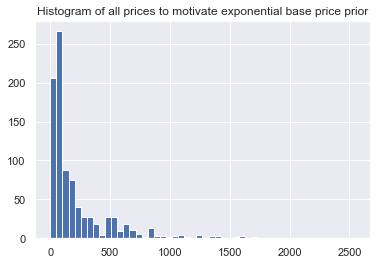

In [675]:
plt.hist(prices, bins = 50)
plt.title("Histogram of all prices to motivate exponential base price prior")
plt.show()

In [685]:
#Build the stan model
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  

    int<lower=1> n;           
    real<lower=0> Prices[n];                     // number of observed prices collected
    int<lower=1, upper=10> Product[n];           // number of products
    int<lower=1, upper=5> Store[n];           // number of stores
    int<lower=1, upper=10> Neigh[n];           // number of  neighboorhood 
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    real<lower=0> base_price[10];       //vector containing base prices of each product
    real<lower=0> mul_store[5];        //vector containing store multipliers
    real<lower=0> mul_neigh[10];        //vector containing neighboorhood multipliers
    real<lower=0> sigma;               
    real<lower=0> lambda;           

}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma ~ gamma(1, 2);      //generate random noise for sigma parameter of normal distribution
    lambda ~ gamma(1, 200);      //generate noise around lambda parameter of base price exponential


    for (i in 1:10) { //base price prior
        base_price[Product[i]] ~ exponential(lambda);   //base price
    };
    
    for (i in 1:5) { //store prior
        mul_store[Store[i]] ~ cauchy(1, 0.5);  //store multiplier
    };
    
    for (i in 1:10) { //neighboorhood prior
        mul_neigh[Neigh[i]] ~ cauchy(1, 0.5);    //neighbourhood multiplier
    }
    
    for(i in 1:n) { //likelihood function
        Prices[i] ~ normal(base_price[Product[i]] * mul_store[Store[i]] * mul_neigh[Neigh[i]], sigma); 
  }
  
}

"""

#compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b411f0838ff5e1a42abf40c5d96cd1c8 NOW.


In [477]:
#stan input data
stan_data = {
                'n': len(prices),
                'Prices': prices,
                'Product': products,
                'Store': stores,
                'Neigh': neighs,   
            }

In [686]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results = stan_model.sampling(data=stan_data)
posterior = stan_results.extract()

# Questions to Answer

## What is the basic average price for each product?

An individual egg is the cheapest good at an average base price of 25 pesos, while the most expensive good is a kilogram of butter. Basic average price for each product can be observed in the table below. 

Inference for Stan model: anon_model_b411f0838ff5e1a42abf40c5d96cd1c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
base_price[1]  107.92   10.98  17.41  86.05 101.75 145.84      3   2.71
base_price[2]   63.51   10.34  16.64   36.1  65.18  94.38      3    2.3
base_price[3]  120.23    9.19  16.23 100.93 115.19 167.84      3   2.37
base_price[4]    68.7    2.64   9.28  47.01  69.88  86.93     12   1.72
base_price[5]   51.01    4.69   9.66  35.33  50.77  70.87      4   1.64
base_price[6]   78.26     8.5  13.92  57.84  75.74 109.22      3   2.18
base_price[7]   90.59     6.2  11.57  74.93   87.5  118.0      3   1.93
base_price[8]   479.0   38.46  56.36  416.9 455.92  598.2      2   4.52
base_price[9]   25.09    5.35   9.64   7.63  25.51  44.91      3   1.86
base_price[10] 230.99   19.47  28.95 194.43 221.18 293.68      2   3.54

Samples were drawn

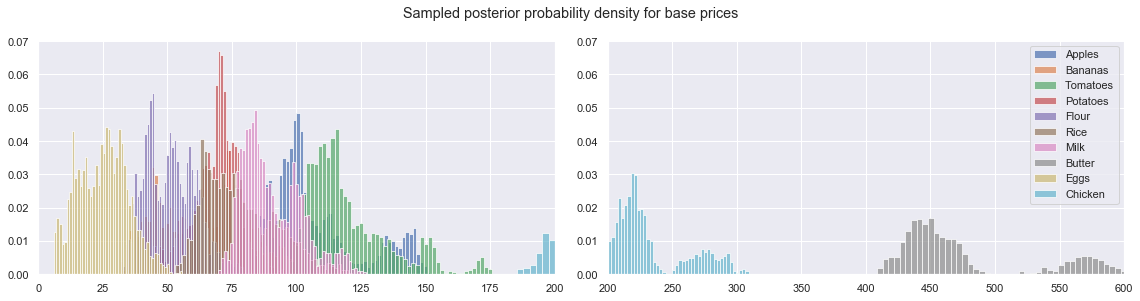

In [694]:
print(stan_results.stansummary(pars=['base_price'], probs=[0.025, 0.5, 0.975]))

plt.figure(figsize = (16,8))
plt.suptitle('Sampled posterior probability density for base prices')

plt.subplot(2, 2, 1)
for i in range(10):
    plt.hist(posterior['base_price'][:,i],bins=50, density = True, alpha = 0.7, label = product_di[i+1]) 
plt.xlim((0,200))## What is the basic average price for each product?

plt.subplot(2, 2, 2)
for i in range(0,10):
    plt.hist(posterior['base_price'][:,i],bins=50, density = True, alpha = 0.7, label = product_di[i+1]) 
plt.xlim((200,600))## What is the basic average price for each product?
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## How much does each brand of the grocery store modify the basic price of the product (up or down)?

Carrefour is the cheapest brand modifier, while Safeway is the most expensive. I neglected to graph Safeway on the plot below and the multiplier mean for Safeway suggest that I failed to accurately model Safeway's multiplier. The unreasonably large Safeway multipler shows how prices in San Francisco are much more expensive than Buenoes Aires or Taipei.Wellcome is the next most expensive modifer, and shares much overlap with the other three Argentinian based brands. 

Inference for Stan model: anon_model_b411f0838ff5e1a42abf40c5d96cd1c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd     2.5%      50%   97.5%  n_eff   Rhat
mul_store[1]    1.05    0.06   0.09     0.89     1.05    1.21      3   2.56
mul_store[2]    1.13    0.08   0.13      0.9     1.15    1.38      3   2.69
mul_store[3]    0.98    0.07    0.1     0.79     0.99    1.14      2   3.07
mul_store[4] 1.7e301     nan    inf 2.5e-301 3.7e-154 8.0e222    nan    nan
mul_store[5]    1.18    0.08   0.13     0.95     1.19    1.39      2   2.79

Samples were drawn using NUTS at Sun Mar 22 18:23:35 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


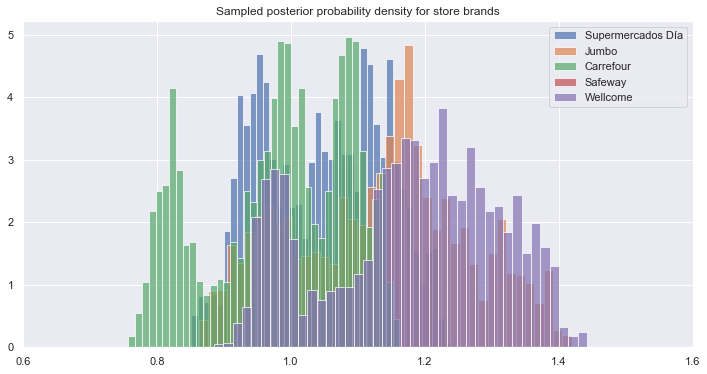

In [693]:
print(stan_results.stansummary(pars=['mul_store'], probs=[0.025, 0.5, 0.975]))


plt.figure(figsize = (12,6))
plt.title('Sampled posterior probability density for store brands')
for i in range(5):
    plt.hist(posterior['mul_store'][:,i],bins=40, density=True, alpha = 0.7, label = store_di[i+1]) 
plt.xlim((0.6,1.6))    
plt.legend()

plt.show()

## How much does the geographical location of the grocery store modify the basic price of the product (up or down)?

Most of the Argentinian neighbourhoods share similar multipliers, with Montserrat being the cheapest and Colegiales being the most expensive within Buenos Aires. Taipei is approximately twice as expensive as Buenoes Aires, and San Francisco I failed to model accurately again. The unreasonably large San Francisco multipler shows how prices in San Francisco are much more expensive than Buenoes Aires or Taipei.

Inference for Stan model: anon_model_b411f0838ff5e1a42abf40c5d96cd1c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd     2.5%     50%   97.5%  n_eff   Rhat
mul_neigh[1]     1.07    0.04   0.08     0.94    1.06    1.24      4   1.58
mul_neigh[2]     1.15    0.03   0.14     0.84    1.15    1.45     20   1.17
mul_neigh[3]      1.2    0.02   0.09     1.02     1.2    1.39     19   1.28
mul_neigh[4]     1.25    0.04   0.13     0.99    1.25    1.51      9   1.46
mul_neigh[5]     1.07    0.06   0.12     0.85    1.08    1.28      3   1.95
mul_neigh[6]     1.13    0.03   0.08      1.0    1.12    1.32      6    1.7
mul_neigh[7]      1.2    0.04   0.09     1.06    1.19     1.4      5   1.44
mul_neigh[8]     1.16    0.02    0.1     0.99    1.16    1.36     19   1.29
mul_neigh[9]  5.0e303     nan    inf 4.0e-223 6.3e153 1.0e301    nan    nan
mul_neigh[10]    2.38    0.03   0.12     2.18    2.

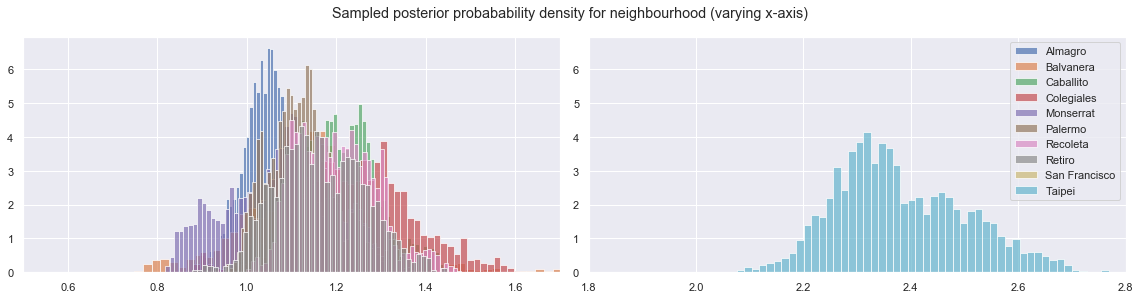

In [698]:
print(stan_results.stansummary(pars=['mul_neigh'], probs=[0.025, 0.5, 0.975]))
Carrefour is the cheapest brand modifier, while Safeway is the most expensive. I neglected to graph Safeway on the plot below and the multiplier mean for Safeway suggest that I failed to accurately model Safeway's multiplier. Wellcome is the next most expensive modifer, and shares much overlap with the other three Argentinian based brands. figsize = (16,8))
plt.suptitle('Sampled posterior probabability density for neighbourhood (varying x-axis)')

plt.subplot(2, 2, 1)
for i in range(10):
    plt.hist(posterior['mul_neigh'][:,i], bins=50, density=True, alpha = 0.7, label = neigh_di[i+1]) 
plt.xlim((0.5,1.7))

plt.subplot(2, 2, 2)
for i in range(10):
    plt.hist(posterior['mul_neigh'][:,i], bins=50, density=True, alpha = 0.7, label = neigh_di[i+1]) 
plt.xlim((1.8,2.8))
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Does price variation by geographical location correlate with variation in rental prices in Buenos Aires, or not?

- Price variation of products by geographical location is moderately correlated with variation in rental prices given a Pearson correlation coefficient (R-Square) of 0.44. 

In [784]:
#rent prices of each neighbourhood using metro station data
Almagro = [4167,4400,4080,4260,4827]
Balvanera = [3500,3850,3580,3750,3750,3880,4480,4600,4250]
Caballito = [4300,4600,3800,4030]
Colegiales = [5600,5121]
Monserrat = [4060,4500,3860,3620,3850]
Palermo = [6050,5100,5633,5720,5114,5055]
Recoleta = [5675,4475,4031]
Retiro = [4600,4700]

neighs = [Almagro,Balvanera,Caballito ,Colegiales,Monserrat,Palermo,Recoleta,Retiro]

#calculate means of each neighbourhood
rent_means = []
for i in neighs:
        rent_means.append(np.mean(i))

neighs_labels = ['Almagro','Balvanera','Caballito' ,'Colegiales',
                 'Monserrat','Palermo','Recoleta','Retiro']

rent = pd.DataFrame((np.mean(posterior['mul_neigh'], axis=0)[:8]).tolist(),columns =['multiplier_means'])
rent['rents_means'] = rent_means
rent['neighbourhoods'] = neighs_labels
rent

,multiplier_means,rents_means,neighbourhoods
0,1.072989,4346.800000,Almagro
1,1.145719,3960.000000,Balvanera
2,1.201835,4182.500000,Caballito
3,1.247411,5360.500000,Colegiales
4,1.071019,3978.000000,Monserrat
5,1.127070,5445.333333,Palermo
6,1.200492,4727.000000,Recoleta
7,1.164271,4650.000000,Retiro


R-Square Correlation Coefficient: 0.4414725532478215


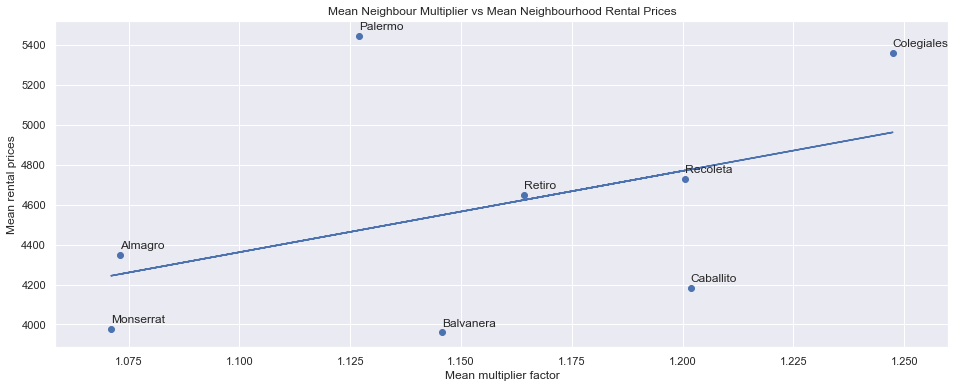

In [797]:
print('R-Square Correlation Coefficient:',rent['multiplier_means'].corr(rent['rents_means']))
x = rent['multiplier_means']
y = rent['rents_means']
b, m = np.polynomial.polynomial.polyfit(x, y, 1)

plt.figure(figsize = (16,6))
plt.scatter(x,y)
plt.plot(x, b + m * x)
plt.xlabel("Mean multiplier factor")
plt.ylabel("Mean rental prices")
plt.title("Mean Neighbour Multiplier vs Mean Neighbourhood Rental Prices")
for i, lab in enumerate(neighs_labels):
    plt.annotate(lab, (x[i], y[i]+30))